In [1]:
# load python packages
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib
import IPython
import sklearn
import keras
import time

Using TensorFlow backend.


In [2]:
# print package version 
print('numpy:', np.__version__)
print('scipy:', sp.__version__)
print('matplotlib:', matplotlib.__version__)
print('iPython:', IPython.__version__)
print('scikit-learn:', sklearn.__version__)
print('keras: ', keras.__version__)
import tensorflow as tf
print('Tensorflow: ', tf.__version__)

('numpy:', '1.14.2')
('scipy:', '1.1.0rc1')
('matplotlib:', '2.1.0')
('iPython:', '5.5.0')
('scikit-learn:', '0.19.1')
('keras: ', '2.1.0')
('Tensorflow: ', '1.4.0')


In [3]:
# load dataset
import scipy.io          
dataset = scipy.io.loadmat('./dataset.mat')

In [4]:
# get training and testing sets
x_train = dataset['train_image']
x_test = dataset['test_image']
y_train = dataset['train_label']
y_test = dataset['test_label']

In [5]:
# P1 KNN clf
def kNN_test(x_train, y_train, x_test, y_test, K):
    dist = [[np.linalg.norm(_x_train - _x_test) 
             for _x_train in x_train] 
            for _x_test in x_test]
    dist = np.array(dist)
    idx = np.argsort(dist, axis=1)
    idx = idx[:, :K]

    y_predict = np.zeros(y_test.shape)
    for i in range(y_test.shape[0]):
        cls_topK = np.unique(y_train[idx[i,:]])
        ncls_topK = [sum(idx[i,:] == _c) for _c in cls_topK]
        major_idx = np.argsort(ncls_topK)
        y_predict[i] = cls_topK[major_idx[-1]]
    
    return np.mean(y_predict == y_test), y_predict

In [6]:
nmb_samples, img_rows, img_cols = x_train.shape[0], x_train.shape[1], x_train.shape[2]
nmb_test_samples = x_test.shape[0]
x_train_vec = x_train.reshape(nmb_samples, img_rows*img_cols)
x_test_vec = x_test.reshape(nmb_test_samples, img_rows*img_cols)

In [7]:
K = [i for i in range(1,11)]
train_acc = [kNN_test(x_train_vec, 
                      y_train,
                      x_train_vec,
                      y_train,
                      _K)[0] 
             for _K in K]

test_acc = []
runtime = []
for _K in K:
    t1 = time.time()
    tmp = kNN_test(x_train_vec, 
                     y_train,
                     x_test_vec,
                     y_test,
                     _K)
    t2 = time.time()
    test_acc.append(tmp[0])
    runtime.append(t2-t1)

print('time ', runtime)
print('test acc ', test_acc)

('time ', [0.26155519485473633, 0.26258111000061035, 0.2598578929901123, 0.2627718448638916, 0.2629539966583252, 0.26354503631591797, 0.26389598846435547, 0.2650289535522461, 0.27019309997558594, 0.26705408096313477])
('test acc ', [0.8, 0.785, 0.71, 0.645, 0.615, 0.58, 0.555, 0.555, 0.55, 0.54])


In [8]:
print('train acc', train_acc)

('train acc', [1.0, 0.905, 0.795, 0.73, 0.655, 0.62, 0.605, 0.585, 0.575, 0.57])


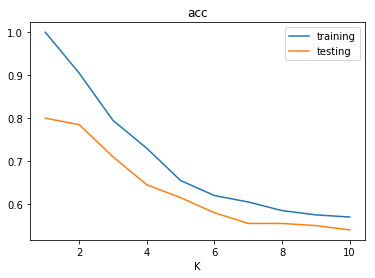

In [9]:
plt.plot(K, train_acc, K, test_acc)
plt.xlabel('K')
plt.title('acc')
plt.legend(['training', 'testing'])

the value of $K$, where generalisation is best, must be 1.

In [10]:
# P2 decision tree
# C4.5 algorithm

height = 1

class node:
    def __init__(self):
        self.children = []
        self.col = -1
        self.height = 0
        self.split = 0.0
        self.label = -1

def entropy(y):
    prob = [np.mean(y == c) for c in np.unique(y)]
    return np.sum([-p*np.log2(p) for p in prob])

def gain(x, col, split, y):
    y_sub_prob = [np.mean(x[:,col] <= split), np.mean(x[:,col] > split)]
    y_sub_ent = [entropy(y[x[:,col] <= split]), entropy(y[x[:,col] > split])]
    return entropy(y) - np.sum(np.array(y_sub_prob)*np.array(y_sub_ent))

def gain_ratio(x, col, split, y):
    y_sub_prob = [np.mean(x[:,col] <= split), np.mean(x[:,col] > split)]
    y_sub_ent = [entropy(y[x[:,col] <= split]), entropy(y[x[:,col] > split])]
    return (entropy(y) - np.sum(np.array(y_sub_prob)*np.array(y_sub_ent))) / entropy(x[:,col]<=split)

def dt_build(x, y, threshold = 0.05):
    if len(np.unique(y)) == 1:
        n = node()
        n.label = np.unique(y)[0]
        return n
    
    if entropy(y) < threshold:  # pre-pruning
        n = node()
        c, count = np.unique(y, return_counts=True)
        n.label = c[np.argmax(count)]
        return n
    
    x_gr = np.zeros(x.shape[1])
    x_split = np.zeros(x.shape[1])
    for col in range(x.shape[1]):
        x_col_sort = np.sort(np.unique(x[:,col]))
        x_col_split = (x_col_sort[:-1] + x_col_sort[1:]) / 2
        x_col_gr = [gain(x, col, split, y) for split in x_col_split]        
        x_split[col] = x_col_split[np.argmax(x_col_gr)]
        x_gr[col] = np.max(x_col_gr)
    
    choose_col = np.argmax(x_gr)
    print('choose col ', choose_col, '; gain information content ', np.max(x_gr))
    n = node()
    n.col = choose_col
    n.split = x_split[choose_col]
    lidx = x[:,n.col] <= n.split
    ridx = x[:,n.col] > n.split
    nx = x
    #nx = np.delete(x, n.col, axis=1)
    n.children = [dt_build(nx[lidx,:], y[lidx], threshold=threshold), 
                  dt_build(nx[ridx,:], y[ridx], threshold=threshold)]
    return n

import copy

def dt_test(tree, x, y):
    z = np.zeros(y.shape)
    for i in range(y.shape[0]):
        tmp = copy.deepcopy(tree)
        while len(tmp.children) != 0:
            if x[i,tmp.col] <= tmp.split:
                tmp = tmp.children[0]
            else:
                tmp = tmp.children[1]
        z[i] = tmp.label
    return np.mean(y == z)

In [11]:
model = dt_build(x_train_vec, y_train, threshold=0.1)

('choose col ', 502, '; gain information content ', 0.13479377861106212)
('choose col ', 504, '; gain information content ', 0.09901096847456303)
('choose col ', 221, '; gain information content ', 0.07753907410251204)
('choose col ', 300, '; gain information content ', 0.07685894780283287)
('choose col ', 537, '; gain information content ', 0.08657102732853394)
('choose col ', 458, '; gain information content ', 0.12843176475156004)
('choose col ', 548, '; gain information content ', 0.11949107660206071)
('choose col ', 218, '; gain information content ', 0.13058823086139837)
('choose col ', 439, '; gain information content ', 0.1462940247002652)
('choose col ', 262, '; gain information content ', 0.1805635859906891)
('choose col ', 522, '; gain information content ', 0.34729178747783596)
('choose col ', 332, '; gain information content ', 0.3323998884020468)
('choose col ', 434, '; gain information content ', 0.5819765115539188)
('choose col ', 4, '; gain information content ', 0.764

In [12]:
dt_test(model, x_test_vec, y_test)

0.595

In [13]:
IC = [0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
train_runtime = []
test_runtime = []
train_acc = []
test_acc = []
for _IC in IC:
    t1 = time.time()
    model = dt_build(x_train_vec, y_train, threshold=_IC)
    t2 = time.time()
    train_runtime.append(t2-t1)
    
    train_acc.append(dt_test(model, x_train_vec, y_train))
    t1 = time.time()
    test_acc.append(dt_test(model, x_test_vec, y_test))
    t2 = time.time()
    test_runtime.append(t2-t1)

print('IC ', IC)
print('training runtime ', train_runtime)
print('training accuracy ', train_acc)
print('testing runtime ', test_runtime)
print('testing accuracy ', test_acc)

('choose col ', 502, '; gain information content ', 0.13479377861106212)
('choose col ', 504, '; gain information content ', 0.09901096847456303)
('choose col ', 221, '; gain information content ', 0.07753907410251204)
('choose col ', 300, '; gain information content ', 0.07685894780283287)
('choose col ', 537, '; gain information content ', 0.08657102732853394)
('choose col ', 458, '; gain information content ', 0.12843176475156004)
('choose col ', 548, '; gain information content ', 0.11949107660206071)
('choose col ', 218, '; gain information content ', 0.13058823086139837)
('choose col ', 439, '; gain information content ', 0.1462940247002652)
('choose col ', 262, '; gain information content ', 0.1805635859906891)
('choose col ', 522, '; gain information content ', 0.34729178747783596)
('choose col ', 332, '; gain information content ', 0.3323998884020468)
('choose col ', 434, '; gain information content ', 0.5819765115539188)
('choose col ', 4, '; gain information content ', 0.764

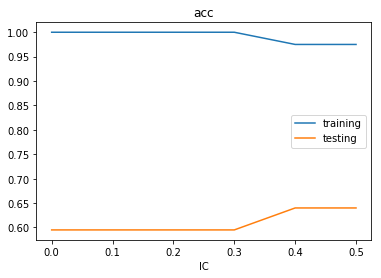

In [14]:
plt.plot(IC, train_acc, IC, test_acc)
plt.xlabel('IC')
plt.title('acc')
plt.legend(['training', 'testing'])

In [5]:
# import keras packages
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras import backend as K

In [6]:
# load dataset        
dataset = scipy.io.loadmat('./dataset.mat')
x_train = dataset['train_image']
x_test = dataset['test_image']
y_train = dataset['train_label']
y_test = dataset['test_label']

# batch size for gradient descent
batch_size = 32
# number of classes
num_classes = 2
# number of epochs (1 epoch = amount of iterations that covers the whole training set)
epochs = 200 # try a larger number of epochs here (for example 10 or larger)
# input image dimensions
nmb_samples, img_rows, img_cols = x_train.shape[0], x_train.shape[1], x_train.shape[2]
nmb_test_samples = x_test.shape[0]

In [7]:
# adjust training image format
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

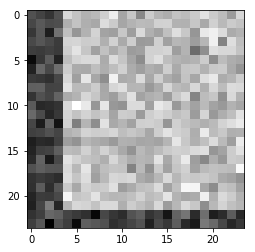

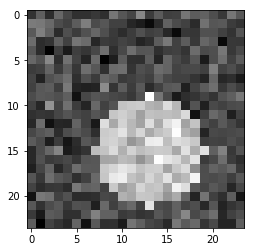

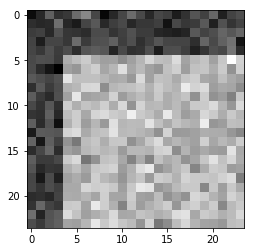

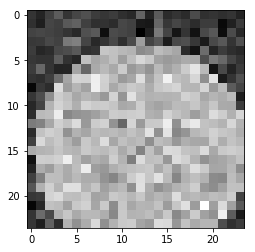

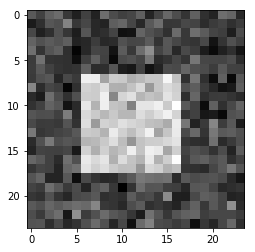

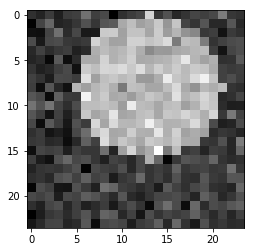

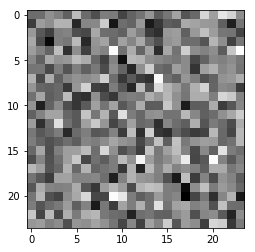

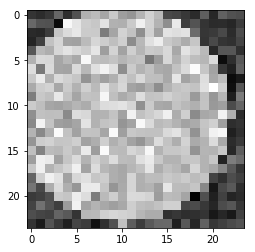

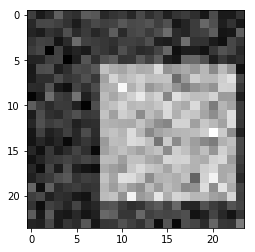

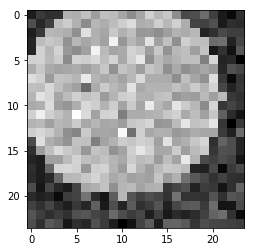

In [8]:
# display some training images
for i in range(10):
    first_image = x_train[i,:,:,0]
    first_image = np.array(first_image, dtype='float')
    pixels = first_image.reshape((img_rows, img_cols))
    plt.imshow(pixels, cmap='gray')
    plt.show()

In [9]:
# convert class vectors to binary class matrices (one hot vectors)
y_train = keras.utils.to_categorical(np.squeeze(y_train), num_classes)
y_test = keras.utils.to_categorical(np.squeeze(y_test), num_classes)

In [10]:
# define LeNet
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [11]:
# compile model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [12]:
# training
t1 = time.time()
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
t2 = time.time()

Train on 200 samples, validate on 200 samples
Epoch 1/200
200/200 [==============================] - 5s 26ms/step - loss: 0.7042 - acc: 0.4800 - val_loss: 0.6904 - val_acc: 0.5000
Epoch 2/200
200/200 [==============================] - 0s 360us/step - loss: 0.7007 - acc: 0.5400 - val_loss: 0.6910 - val_acc: 0.5000
Epoch 3/200
200/200 [==============================] - 0s 353us/step - loss: 0.6828 - acc: 0.6000 - val_loss: 0.7325 - val_acc: 0.5000
Epoch 4/200
200/200 [==============================] - 0s 364us/step - loss: 0.7017 - acc: 0.5000 - val_loss: 0.6851 - val_acc: 0.6350
Epoch 5/200
200/200 [==============================] - 0s 351us/step - loss: 0.6773 - acc: 0.6150 - val_loss: 0.6881 - val_acc: 0.5000
Epoch 6/200
200/200 [==============================] - 0s 407us/step - loss: 0.6825 - acc: 0.5550 - val_loss: 0.6938 - val_acc: 0.5000
Epoch 7/200
200/200 [==============================] - 0s 346us/step - loss: 0.6713 - acc: 0.5900 - val_loss: 0.6872 - val_acc: 0.5050
Epoch 8/20

Epoch 61/200
200/200 [==============================] - 0s 311us/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.0725 - val_acc: 0.9800
Epoch 62/200
200/200 [==============================] - 0s 338us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0541 - val_acc: 0.9800
Epoch 63/200
200/200 [==============================] - 0s 362us/step - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0533 - val_acc: 0.9850
Epoch 64/200
200/200 [==============================] - 0s 342us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.0497 - val_acc: 0.9900
Epoch 65/200
200/200 [==============================] - 0s 339us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0619 - val_acc: 0.9850
Epoch 66/200
200/200 [==============================] - 0s 331us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0522 - val_acc: 0.9850
Epoch 67/200
200/200 [==============================] - 0s 369us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0455 - val_acc: 0.9850
Epoch 68/200
200/200 [==========================

200/200 [==============================] - 0s 339us/step - loss: 1.9657e-04 - acc: 1.0000 - val_loss: 0.0753 - val_acc: 0.9800
Epoch 121/200
200/200 [==============================] - 0s 329us/step - loss: 1.3581e-04 - acc: 1.0000 - val_loss: 0.0621 - val_acc: 0.9850
Epoch 122/200
200/200 [==============================] - 0s 335us/step - loss: 1.9650e-04 - acc: 1.0000 - val_loss: 0.0606 - val_acc: 0.9850
Epoch 123/200
200/200 [==============================] - 0s 345us/step - loss: 1.6207e-04 - acc: 1.0000 - val_loss: 0.0603 - val_acc: 0.9850
Epoch 124/200
200/200 [==============================] - 0s 353us/step - loss: 1.1940e-04 - acc: 1.0000 - val_loss: 0.0659 - val_acc: 0.9850
Epoch 125/200
200/200 [==============================] - 0s 377us/step - loss: 1.6227e-04 - acc: 1.0000 - val_loss: 0.0661 - val_acc: 0.9850
Epoch 126/200
200/200 [==============================] - 0s 408us/step - loss: 1.3613e-04 - acc: 1.0000 - val_loss: 0.0605 - val_acc: 0.9850
Epoch 127/200
200/200 [====

200/200 [==============================] - 0s 361us/step - loss: 5.4533e-05 - acc: 1.0000 - val_loss: 0.0687 - val_acc: 0.9850
Epoch 179/200
200/200 [==============================] - 0s 357us/step - loss: 5.2167e-05 - acc: 1.0000 - val_loss: 0.0712 - val_acc: 0.9850
Epoch 180/200
200/200 [==============================] - 0s 331us/step - loss: 4.8843e-05 - acc: 1.0000 - val_loss: 0.0709 - val_acc: 0.9850
Epoch 181/200
200/200 [==============================] - 0s 353us/step - loss: 5.0177e-05 - acc: 1.0000 - val_loss: 0.0738 - val_acc: 0.9850
Epoch 182/200
200/200 [==============================] - 0s 353us/step - loss: 5.3112e-05 - acc: 1.0000 - val_loss: 0.0872 - val_acc: 0.9850
Epoch 183/200
200/200 [==============================] - 0s 355us/step - loss: 5.0580e-05 - acc: 1.0000 - val_loss: 0.0714 - val_acc: 0.9850
Epoch 184/200
200/200 [==============================] - 0s 413us/step - loss: 4.0506e-05 - acc: 1.0000 - val_loss: 0.0719 - val_acc: 0.9850
Epoch 185/200
200/200 [====

In [13]:
# print train and test losses and classification accuracies
print('training time, ', t2-t1)

score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
t1 = time.time()
score = model.evaluate(x_test, y_test, verbose=0)
t2 = time.time()
print('testing time, ', t2-t1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

('training time, ', 20.595954179763794)
('Train loss:', 2.0810966852877754e-05)
('Train accuracy:', 1.0)
('testing time, ', 0.02232503890991211)
('Test loss:', 0.06802781160920858)
('Test accuracy:', 0.985)


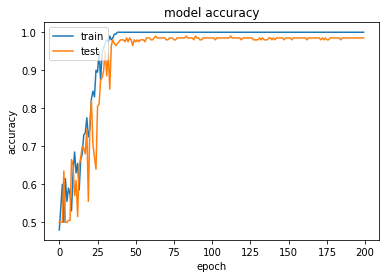

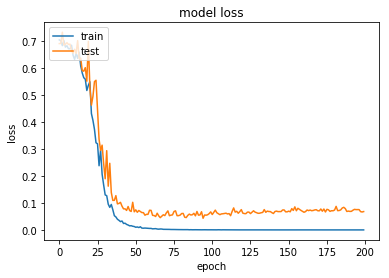

In [14]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[0.02569998 0.0329023  0.03658417 0.03788112 0.03899948 0.03956822
 0.04146465 0.04737055 0.04365301 0.05827225 0.04375132 0.04469708
 0.0455665  0.05055225 0.04921186 0.04659267 0.04237656 0.03774918
 0.042409   0.03988333 0.03319136 0.02842506 0.02801655 0.01991258
 0.03746806 0.04018486 0.04205803 0.04656271 0.0505125  0.05323464
 0.05124555 0.05523592 0.05276084 0.05803249 0.05752019 0.05617123
 0.05573309 0.05873853 0.0599565  0.05767156 0.05611209 0.04907218
 0.05015267 0.04240472 0.03775554 0.03376576 0.02870449 0.02284262
 0.03509185 0.03951832 0.05027428 0.05480395 0.04957435 0.05620831
 0.06638559 0.06274372 0.05516003 0.06365773 0.06514715 0.06145165
 0.06392594 0.0675129  0.05703187 0.05723546 0.06136958 0.05697515
 0.05527093 0.05306605 0.04381475 0.04320288 0.03283041 0.03032833
 0.0388562  0.04990136 0.05929438 0.05154394 0.05991545 0.05753338
 0.06303034 0.06480517 0.06174197 0.05857897 0.06067646 0.05780281
 0.05866599 0.0623491  0.05450298 0.06610634 0.06088831 0.0641

(array([ 23.,  26.,  22.,  24.,  59.,  62.,  75.,  99., 127.,  59.]),
 array([0.0094309 , 0.01527551, 0.02112011, 0.02696472, 0.03280932,
        0.03865393, 0.04449853, 0.05034313, 0.05618774, 0.06203234,
        0.06787695]),
 <a list of 10 Patch objects>)

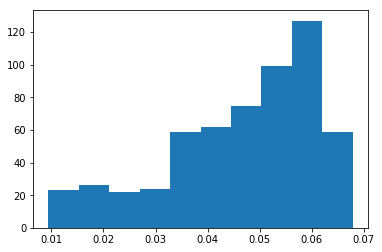

In [11]:
var = np.array([np.var(x_train_vec[:,c]) for c in range(x_train_vec.shape[1])])
print var
print min(var)
print max(var)
plt.hist(var)

In [14]:
nx_train_vec = x_train_vec[:, var >= 0.05]
nx_test_vec = x_test_vec[:, var >= 0.05]
print('x_train shape ', nx_train_vec.shape)
print('x_test shape ', nx_test_vec.shape)

t1 = time.time()
model = dt_build(nx_train_vec, y_train, threshold=0.1)
t2 = time.time()
print('training time ', t2-t1)

train_acc = dt_test(model, nx_train_vec, y_train)
print('training acc ', train_acc)
t1 = time.time()
test_acc = dt_test(model, nx_test_vec, y_test)
t2 = time.time()
print('testing time ', t2-t1)
print('testing acc ', test_acc)

('x_train shape ', (200, 291))
('x_test shape ', (200, 291))
('choose col ', 272, '; gain information content ', 0.10688591034645722)
('choose col ', 245, '; gain information content ', 0.09075140515243185)
('choose col ', 182, '; gain information content ', 0.09168920790179558)
('choose col ', 204, '; gain information content ', 0.3975760379157159)
('choose col ', 194, '; gain information content ', 0.3227569588973982)
('choose col ', 281, '; gain information content ', 0.15085093174190756)
('choose col ', 199, '; gain information content ', 0.19299827493687083)
('choose col ', 53, '; gain information content ', 0.2916979827156446)
('choose col ', 202, '; gain information content ', 0.3881115531547389)
('choose col ', 35, '; gain information content ', 0.6548575458269758)
('choose col ', 3, '; gain information content ', 0.6500224216483541)
('choose col ', 237, '; gain information content ', 0.23201238816811887)
('choose col ', 182, '; gain information content ', 0.38306898300392245)
